**Golf score and head-to-head predictions**

Use of historical golf scoring data for predictive analysis: 
- Build predictive models for professional golf (US PGA & European Tour) events using privately curated datasets with features engineered to represent form going into a contest

Golf is a very difficult sport to make predictions on due to a number of factors:
- **Large number of players:** Field sizes vary from 30-156 players per event
- **Weather:** Sun, wind and rain all play a big role in scoring.  Tournaments are played over 4 days with the weather constantly changing 
- **Variety of course setups:** Links / parkland / length / grass types / rough length / green speed etc.
- **Variety of locations:** Tournaments are played all over the world with different climates and conditions affecting players differently
- **Player form:** All professional players go through several peaks and troughs in their career.  These are very difficult to predict and a professional golfer can go from hero-to-zero and visa versa for no apparent reason
- **Luck:** The bounce of the ball can play a large roll in outcomes

As such, success rates of predictions are low relative to predictions in other sports, e.g. in Football, Tennis, Horse Racing etc.  This is reflected by the high odds that one can get from bookmakers - favorites typically come in around 6-12/1, midrange players around 20-80/1 and the rest can vary from 100-1000/1

- Goal:

Make score and head-to-head predictions using the latest ML & AI techniques.  These will be baselined against historical odds betting data to determine whether or not models can match / beat experts.

- Inspiration:

https://www.bloomberg.com/news/features/2018-05-03/the-gambler-who-cracked-the-horse-racing-code

https://www.bloomberg.com/news/videos/2020-01-09/the-man-who-beat-horse-racing-and-made-close-to-a-billion-dollars-video


**PGA Round-2: 3-ball head-to-head winner prediction:**




In [ ]:
#!pip install -U matplotlib

In [ ]:
import pandas as pd
import numpy as np
import sys, os

run_colab=1

file_name = 'PGA_R2_3b_classification.csv'
init_file_name = 'PGA_R2_3b_classification - Initial.csv'
tour_ind = ['PGA']
r_ind = [2]
g_ind = [3]


m_ho = 100
split = 0.15
k_fold = 10

if run_colab==1:
  from google.colab import drive
  drive.mount('/content/drive')
  data = pd.read_csv('/content/drive/MyDrive/ML_Golf_Betting/GitHub/'+file_name)
else:
  data = pd.read_csv(file_name)

base_cols = list(data.columns)
print(f'({data.shape}) {base_cols}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
((4827, 325)) ['Year_c', 'Month_c', 'Day_c', 'tName_c', 'date_ind', 'pod_id', 'pod_pls', 'pl_back', 'pl_lay', 'm_c', 'DSLT', 'Length_n', 'Length_sg1', 'Length_sg2', 'Length_sg3', 'Length_sg4', 'Length_sgT', 'Length_n_1st_grp', 'Length_n_2nd_grp', 'Length_n_3rd_grp', 'Length_n_4th_grp', 'Length_n_5th_grp', 'Length_n_6th_grp', 'Length_n_7th_grp', 'Length_n_8th_grp', 'Length_n_9th_grp', 'Length_n_10th_grp', 'Length_n_W', 'Ptype_n', 'Ptype_sg1', 'Ptype_sg2', 'Ptype_sg3', 'Ptype_sg4', 'Ptype_sgT', 'Ptype_n_1st_grp', 'Ptype_n_2nd_grp', 'Ptype_n_3rd_grp', 'Ptype_n_4th_grp', 'Ptype_n_5th_grp', 'Ptype_n_6th_grp', 'Ptype_n_7th_grp', 'Ptype_n_8th_grp', 'Ptype_n_9th_grp', 'Ptype_n_10th_grp', 'Ptype_n_W', 'Region_n', 'Region_sg1', 'Region_sg2', 'Region_sg3', 'Region_sg4', 'Region_sgT', 'Region_n_1st_grp', 'Region_n_2nd_grp', 'Region_n_3rd_grp', 'Region_n_4th_grp', 'Region

In [ ]:
print(data.shape)
data.head(3)

(4827, 325)


,Year_c,Month_c,Day_c,tName_c,date_ind,pod_id,pod_pls,pl_back,pl_lay,m_c,DSLT,Length_n,Length_sg1,Length_sg2,Length_sg3,Length_sg4,Length_sgT,Length_n_1st_grp,Length_n_2nd_grp,Length_n_3rd_grp,Length_n_4th_grp,Length_n_5th_grp,Length_n_6th_grp,Length_n_7th_grp,Length_n_8th_grp,Length_n_9th_grp,Length_n_10th_grp,Length_n_W,Ptype_n,Ptype_sg1,Ptype_sg2,Ptype_sg3,Ptype_sg4,Ptype_sgT,Ptype_n_1st_grp,Ptype_n_2nd_grp,Ptype_n_3rd_grp,Ptype_n_4th_grp,Ptype_n_5th_grp,Ptype_n_6th_grp,...,tb2_sg1,tb2_p1,tb2_R1_ld_def,tb2_sg2,tb2_p2,tb2_R2_ld_def,tb2_sg3,tb2_p3,tb2_R3_ld_def,tb2_sg4,tb2_sgT,tb2_pT,tb2_fng,tb2_R4_ld_def,dslt_2,tb1_sg1,tb1_p1,tb1_R1_ld_def,tb1_sg2,tb1_p2,tb1_R2_ld_def,tb1_sg3,tb1_p3,tb1_R3_ld_def,tb1_sg4,tb1_sgT,tb1_pT,tb1_fng,tb1_R4_ld_def,dslt_1,R1_scr,R1_ld_def,R1_pos,R1_vFavg,R_scr,win_ind,fav_ind,mid_ind,weak_ind,tie_flag
0,2018,3,29,Houston Open (USA) - Play Offs,2018_3_29,2018_3_29_v0_d2_grp12_PGA,scott brown,3.40,3.60,144,14,10,0.484306,0.963049,0.763103,-2.959508,-0.447743,2,1,1,0,2,0,1,2,0,1,0,26,0.450311,-0.600281,0.260695,-1.317680,-0.405198,2,1,4,4,3,0,...,0.839161,48,-5,1.286713,38,-7,-1.320513,50,-11,-1.974359,-4.205128,64,4,-14,14,-0.798319,68,-9,-3.941176,103,-16,0.00000,104,-30,0.00,0.000000,104,8,-30,7,-1,-7,93,-1.223776,-2,1,0,1,0,0
1,2018,3,29,Houston Open (USA) - Play Offs,2018_3_29,2018_3_29_v0_d2_grp12_PGA,thomas pieters,2.04,2.18,144,28,10,-0.186166,-0.094862,1.326734,-1.042217,0.156006,3,0,0,0,1,2,1,1,1,1,0,26,0.183811,1.399090,0.439362,-0.319204,0.755463,6,4,1,1,4,2,...,3.557143,12,-3,3.178571,7,-2,-0.093333,11,-7,0.480000,3.760000,13,0,-9,7,1.750000,13,-5,2.109375,14,-6,-3.71875,32,-11,-1.75,-1.609375,37,5,-15,7,-3,-5,49,0.776224,0,0,1,0,0,0
2,2018,3,29,Houston Open (USA) - Play Offs,2018_3_29,2018_3_29_v0_d2_grp12_PGA,martin piller,3.85,4.50,144,14,3,-0.444100,-0.941147,1.692308,-4.589744,-1.346154,0,0,1,0,0,1,0,0,0,1,0,13,0.753689,0.330114,1.005099,-1.430114,-0.127980,2,1,1,2,1,3,...,-3.160839,122,-9,-5.713287,140,-18,0.000000,140,-30,0.000000,0.000000,140,9,-30,14,-2.798319,95,-11,-4.941176,113,-19,0.00000,114,-30,0.00,0.000000,114,9,-30,7,-4,-4,24,1.776224,1,0,0,0,1,0


In [ ]:
data.isna().sum()

Year_c      0
Month_c     0
Day_c       0
tName_c     0
date_ind    0
           ..
win_ind     0
fav_ind     0
mid_ind     0
weak_ind    0
tie_flag    0
Length: 325, dtype: int64

In [ ]:
data.nunique()

Year_c        5
Month_c      12
Day_c        31
tName_c      78
date_ind    139
           ... 
win_ind       2
fav_ind       2
mid_ind       2
weak_ind      2
tie_flag      3
Length: 325, dtype: int64

In [ ]:
data.describe(include='all').iloc[:,-10:-5]
#As of pandas v15.0, use the parameter, DataFrame.describe(include = 'all') to get a summary of all the columns when the dataframe has mixed column types. 
#The default behavior is to only provide a summary for the numerical columns.

,R1_scr,R1_ld_def,R1_pos,R1_vFavg,R_scr
count,4827.000000,4827.000000,4827.000000,4827.000000,4827.000000
unique,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN
mean,-0.024446,-6.679925,54.477522,0.448764,-0.315103
std,3.628841,3.210933,40.548095,2.962891,3.587972
min,-10.000000,-23.000000,1.000000,-15.525641,-12.000000
25%,-3.000000,-9.000000,19.000000,-1.395833,-3.000000
50%,0.000000,-7.000000,47.000000,0.604167,-1.000000
75%,2.000000,-4.000000,85.000000,2.496552,2.000000


In [ ]:
# number of groups with favourite, mid and weak player identified based on bookies odds (when available)
m_grp_with_p012 = len(data)/ 3 
#Calculate win percentages for bookies favourite, mid and weakest players
fav_w = data.loc[(data['fav_ind']==1) & (data['win_ind']==1)].shape[0] / m_grp_with_p012
mid_w = data.loc[(data['mid_ind']==1) & (data['win_ind']==1)].shape[0] / m_grp_with_p012
weak_w = data.loc[(data['weak_ind']==1) & (data['win_ind']==1)].shape[0] / m_grp_with_p012


print('Win percentages for bookies favourite, mid and weakest players [Precision : TP / predicted yes(TP+FP)]')
print(f'fav_w={round(fav_w,4)}, mid_w={round(mid_w,4)}, weak_w={round(weak_w,4)} across {m_grp_with_p012} groups (*including ties)')

Win percentages for bookies favourite, mid and weakest players [Precision : TP / predicted yes(TP+FP)]
fav_w=0.486, mid_w=0.3654, weak_w=0.3021 across 1609.0 groups (*including ties)


In [ ]:
#Drop groups without favourite, mid and weak player identified
data_with_p012 = data.copy()

In [ ]:
#Flatten each group (currently represented by 3 rows per group) to into a single row per group
tourn_cols = list(data_with_p012.columns[:5])
pl_col = data_with_p012.columns[6]
x_cols = list(data_with_p012.columns[7:-6])
y_cols = list(data_with_p012.columns[-6:])
pl_id = ['p0','p1','p2'] #tags to id players (fav, mid, weak)
p0_cols, p1_cols, p2_cols = [],[],[]
p012_cols = None
y_dict={0:[1,0,0], 1:[0,1,0], 2:[0,0,1], 3:[1,1,0], 4:[1,0,1], 5:[0,1,1], 6:[1,1,1]}

df_flat = pd.DataFrame({'pod_id':list(data_with_p012['pod_id'].unique())})
for i in range(len(df_flat)):
#for i in [0]:
    if i==0: #initialize all columns
        for c in tourn_cols: df_flat[c]=[None]*len(df_flat)
        for pl in pl_id: 
          df_flat[pl+'_'+pl_col]=[None]*len(df_flat)
          if pl=='p0':p0_cols.append(pl+'_'+pl_col)
          if pl=='p1':p1_cols.append(pl+'_'+pl_col)
          if pl=='p2':p2_cols.append(pl+'_'+pl_col)    
        for pl in pl_id:
            for x in x_cols: 
              df_flat[pl+'_'+x]=[None]*len(df_flat)
              if pl=='p0':p0_cols.append(pl+'_'+x)
              if pl=='p1':p1_cols.append(pl+'_'+x)
              if pl=='p2':p2_cols.append(pl+'_'+x)
        for pl in pl_id:
            for y in y_cols: 
              df_flat[pl+'_'+y]=[None]*len(df_flat)
              if pl=='p0':p0_cols.append(pl+'_'+y)
              if pl=='p1':p1_cols.append(pl+'_'+y)
              if pl=='p2':p2_cols.append(pl+'_'+y)
        df_flat['y_target']=[None]*len(df_flat)

        p012_cols=[p0_cols, p1_cols, p2_cols]
        X_features = p0_cols[1:-6]+p1_cols[1:-6]+p2_cols[1:-6]
        Y_classes = [p0_cols[-5], p1_cols[-5], p2_cols[-5]]

    #Populate df_flat
    temp_df = data_with_p012[data_with_p012['pod_id']==df_flat.loc[i,'pod_id']].reset_index()
    df_flat.loc[i,tourn_cols] = temp_df.loc[0,tourn_cols]
    #get fav, mid & weak inds
    p0_ind = temp_df.loc[temp_df['fav_ind']==1].index[0]
    p1_ind = temp_df.loc[temp_df['mid_ind']==1].index[0]
    p2_ind = temp_df.loc[temp_df['weak_ind']==1].index[0]
    p012_ind=[p0_ind, p1_ind, p2_ind]
    for j in range(len(pl_id)):
      df_flat.loc[i,p012_cols[j][0]] = temp_df.loc[p012_ind[j],'pod_pls']
      df_flat.loc[i,p012_cols[j][1:-6]] = temp_df.loc[p012_ind[j],x_cols].values
      df_flat.loc[i,p012_cols[j][-6:]] = temp_df.loc[p012_ind[j],y_cols].values
    #Calculate y_target
    win_lst = list(df_flat.loc[i,Y_classes])
    if [1,0,0]==win_lst: df_flat.loc[i,'y_target']=0
    if [0,1,0]==win_lst: df_flat.loc[i,'y_target']=1
    if [0,0,1]==win_lst: df_flat.loc[i,'y_target']=2
    if [1,1,0]==win_lst: df_flat.loc[i,'y_target']=3
    if [1,0,1]==win_lst: df_flat.loc[i,'y_target']=4
    if [0,1,1]==win_lst: df_flat.loc[i,'y_target']=5
    if [1,1,1]==win_lst: df_flat.loc[i,'y_target']=6

print(df_flat.columns)
print(df_flat.shape)
print(f'{len(p0_cols)}, {len(p1_cols)}, {len(p2_cols)}')

Index(['pod_id', 'Year_c', 'Month_c', 'Day_c', 'tName_c', 'date_ind',
       'p0_pod_pls', 'p1_pod_pls', 'p2_pod_pls', 'p0_pl_back',
       ...
       'p1_mid_ind', 'p1_weak_ind', 'p1_tie_flag', 'p2_R_scr', 'p2_win_ind',
       'p2_fav_ind', 'p2_mid_ind', 'p2_weak_ind', 'p2_tie_flag', 'y_target'],
      dtype='object', length=964)
(1609, 964)
319, 319, 319


In [ ]:
print(f'X_features = {X_features}')
print(f'Y_classes = {Y_classes}')
print(f'y_dict = {y_dict}')
print(f'x_cols = {x_cols}')
print(f'y_cols = {y_cols}')
print(f'tourn_cols = {tourn_cols}')
print(f'pl_id = {pl_id}')
print(f'pl_col = {pl_col}')
print(f'p012_cols = {p012_cols}')

X_features = ['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT', 'p0_Length_n', 'p0_Length_sg1', 'p0_Length_sg2', 'p0_Length_sg3', 'p0_Length_sg4', 'p0_Length_sgT', 'p0_Length_n_1st_grp', 'p0_Length_n_2nd_grp', 'p0_Length_n_3rd_grp', 'p0_Length_n_4th_grp', 'p0_Length_n_5th_grp', 'p0_Length_n_6th_grp', 'p0_Length_n_7th_grp', 'p0_Length_n_8th_grp', 'p0_Length_n_9th_grp', 'p0_Length_n_10th_grp', 'p0_Length_n_W', 'p0_Ptype_n', 'p0_Ptype_sg1', 'p0_Ptype_sg2', 'p0_Ptype_sg3', 'p0_Ptype_sg4', 'p0_Ptype_sgT', 'p0_Ptype_n_1st_grp', 'p0_Ptype_n_2nd_grp', 'p0_Ptype_n_3rd_grp', 'p0_Ptype_n_4th_grp', 'p0_Ptype_n_5th_grp', 'p0_Ptype_n_6th_grp', 'p0_Ptype_n_7th_grp', 'p0_Ptype_n_8th_grp', 'p0_Ptype_n_9th_grp', 'p0_Ptype_n_10th_grp', 'p0_Ptype_n_W', 'p0_Region_n', 'p0_Region_sg1', 'p0_Region_sg2', 'p0_Region_sg3', 'p0_Region_sg4', 'p0_Region_sgT', 'p0_Region_n_1st_grp', 'p0_Region_n_2nd_grp', 'p0_Region_n_3rd_grp', 'p0_Region_n_4th_grp', 'p0_Region_n_5th_grp', 'p0_Region_n_6th_grp', 'p0_Region_n_7th_grp'

In [ ]:
#Check if multiple favourites (players with tied starting odds) occur in any groups
#If they do (equal_df.shape>0) investigate to see whether fav_w percentage should be ammened and if so by how much 
equal_df = df_flat.loc[df_flat['p0_pl_back']==df_flat['p1_pl_back'], ['pod_id', 'p0_pl_back', 'p1_pl_back', 'p0_win_ind', 'p1_win_ind', 'p2_win_ind']]
equal_df.shape

(0, 6)

In [ ]:
df_flat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609 entries, 0 to 1608
Columns: 964 entries, pod_id to y_target
dtypes: object(964)
memory usage: 11.8+ MB


In [ ]:
df_flat.isnull().values.any()

False

In [ ]:
if run_colab==1:
    os.chdir('/content/drive/MyDrive/ML_Golf_Betting/GitHub/')
df_flat.to_csv('temp_flat.csv', index=False) 

In [ ]:
df_flat.head(3)

,pod_id,Year_c,Month_c,Day_c,tName_c,date_ind,p0_pod_pls,p1_pod_pls,p2_pod_pls,p0_pl_back,p0_pl_lay,p0_m_c,p0_DSLT,p0_Length_n,p0_Length_sg1,p0_Length_sg2,p0_Length_sg3,p0_Length_sg4,p0_Length_sgT,p0_Length_n_1st_grp,p0_Length_n_2nd_grp,p0_Length_n_3rd_grp,p0_Length_n_4th_grp,p0_Length_n_5th_grp,p0_Length_n_6th_grp,p0_Length_n_7th_grp,p0_Length_n_8th_grp,p0_Length_n_9th_grp,p0_Length_n_10th_grp,p0_Length_n_W,p0_Ptype_n,p0_Ptype_sg1,p0_Ptype_sg2,p0_Ptype_sg3,p0_Ptype_sg4,p0_Ptype_sgT,p0_Ptype_n_1st_grp,p0_Ptype_n_2nd_grp,p0_Ptype_n_3rd_grp,p0_Ptype_n_4th_grp,...,p2_tb2_R4_ld_def,p2_dslt_2,p2_tb1_sg1,p2_tb1_p1,p2_tb1_R1_ld_def,p2_tb1_sg2,p2_tb1_p2,p2_tb1_R2_ld_def,p2_tb1_sg3,p2_tb1_p3,p2_tb1_R3_ld_def,p2_tb1_sg4,p2_tb1_sgT,p2_tb1_pT,p2_tb1_fng,p2_tb1_R4_ld_def,p2_dslt_1,p2_R1_scr,p2_R1_ld_def,p2_R1_pos,p2_R1_vFavg,p0_R_scr,p0_win_ind,p0_fav_ind,p0_mid_ind,p0_weak_ind,p0_tie_flag,p1_R_scr,p1_win_ind,p1_fav_ind,p1_mid_ind,p1_weak_ind,p1_tie_flag,p2_R_scr,p2_win_ind,p2_fav_ind,p2_mid_ind,p2_weak_ind,p2_tie_flag,y_target
0,2018_3_29_v0_d2_grp12_PGA,2018,3,29,Houston Open (USA) - Play Offs,2018_3_29,thomas pieters,scott brown,martin piller,2.04,2.18,144,28,10,-0.186166,-0.0948621,1.32673,-1.04222,0.156006,3,0,0,0,1,2,1,1,1,1,0,26,0.183811,1.39909,0.439362,-0.319204,0.755463,6,4,1,1,...,-30,14,-2.79832,95,-11,-4.94118,113,-19,0,114,-30,0,0,114,9,-30,7,-4,-4,24,1.77622,0,0,1,0,0,0,-2,1,0,1,0,0,1,0,0,0,1,0,1
1,2019_5_9_v0_d2_grp5_PGA,2019,5,9,AT-T Byron Nelson (USA),2019_5_9,lucas bjerregaard,harris english,andres romero,2.32,2.76,156,28,14,-1.17245,0.235617,-0.487283,-0.584999,-2.97375,0,2,2,2,0,3,2,0,2,1,0,12,1.34027,1.33748,-0.767955,0.48217,0.270792,3,2,1,1,...,-9,21,-3.04688,108,-9,-5.3125,120,-17,0,122,-30,0,0,122,9,-30,35,-4,-4,22,2.75163,1,0,1,0,0,0,0,1,0,1,0,0,5,0,0,0,1,0,1
2,2019_10_3_v0_d2_grp1_PGA,2019,10,3,Shriners Hospitals for Children Open (USA) - P...,2019_10_3,brandt snedeker,ryan armour,grayson murray,2.12,2.34,144,7,40,0.461436,1.69042,1.01693,0.527899,1.92326,11,6,7,4,4,2,2,2,1,1,1,12,-0.214759,1.60346,1.1986,0.514926,1.20699,3,2,0,2,...,-30,7,-0.472222,73,-7,-2.65972,109,-14,0,116,-30,0,0,116,7,-30,7,0,-8,111,-1.77083,-1,1,1,0,0,0,0,0,0,1,0,0,3,0,0,0,1,0,0


In [ ]:
#Veracity Check Data
#grp_id = '2018_3_29_v0_d2_grp12_PGA'
grp_id = '2021_10_21_v0_d2_grp9_PGA'
print(data_with_p012.loc[data_with_p012['pod_id']==grp_id, ['pod_pls','pl_back','Length_sg1','tb12_p1','R_scr', 'win_ind']])
print()
print(df_flat.loc[df_flat['pod_id']==grp_id, ['p0_pod_pls','p0_pl_back','p0_Length_sg1','p0_tb12_p1','p0_R_scr', 'p0_win_ind']])
print()
print(df_flat.loc[df_flat['pod_id']==grp_id, ['p1_pod_pls','p1_pl_back','p1_Length_sg1','p1_tb12_p1','p1_R_scr', 'p1_win_ind']])
print()
print(df_flat.loc[df_flat['pod_id']==grp_id, ['p2_pod_pls','p2_pl_back','p2_Length_sg1','p2_tb12_p1','p2_R_scr', 'p2_win_ind']])
print()
print(df_flat.loc[df_flat['pod_id']==grp_id, 'y_target'])

              pod_pls  pl_back  Length_sg1  tb12_p1  R_scr  win_ind
4824  emiliano grillo     2.42    1.032186       41      0        0
4825    kramer hickok     3.20   -0.091293      110      4        0
4826         chan kim     3.25   -0.872304      141     -4        1

           p0_pod_pls p0_pl_back p0_Length_sg1 p0_tb12_p1 p0_R_scr p0_win_ind
1608  emiliano grillo       2.42       1.03219         41        0          0

         p1_pod_pls p1_pl_back p1_Length_sg1 p1_tb12_p1 p1_R_scr p1_win_ind
1608  kramer hickok        3.2    -0.0912934        110        4          0

     p2_pod_pls p2_pl_back p2_Length_sg1 p2_tb12_p1 p2_R_scr p2_win_ind
1608   chan kim       3.25     -0.872304        141       -4          1

1608    2
Name: y_target, dtype: object


In [ ]:
#Generate datasets for 3-way data splits
# 1) ho_data
ho_data = df_flat.iloc[-m_ho:].copy()
ho_data.reset_index(inplace=True)
ho_data.drop('index', axis=1, inplace=True)
#Generate X & Y Dataframes
X_ho_df = ho_data.loc[:,X_features]     # pl_back_dX -> R1_vFavg for p123
Y_ho_df = ho_data.loc[:,'y_target']     # y_target for p012
Y_ho_df_oh = ho_data.loc[:,Y_classes]   # win_ind_dX for p123
print(f'X_ho_df={type(X_ho_df)}, {X_ho_df.shape}, {X_ho_df.values[0,0:5]}')
print(f'Y_ho_df={type(Y_ho_df.values)}, {Y_ho_df.shape}, {Y_ho_df.values[0]}')
print(f'Y_ho_df_oh={type(Y_ho_df_oh.values)}, {Y_ho_df_oh.shape}, {Y_ho_df_oh.values[0]}')
#
print(ho_data.shape)
ho_data.head(1)

X_ho_df=<class 'pandas.core.frame.DataFrame'>, (100, 936), [2.36 2.42 156 21 21]
Y_ho_df=<class 'numpy.ndarray'>, (100,), 1
Y_ho_df_oh=<class 'numpy.ndarray'>, (100, 3), [0 1 0]
(100, 964)


,pod_id,Year_c,Month_c,Day_c,tName_c,date_ind,p0_pod_pls,p1_pod_pls,p2_pod_pls,p0_pl_back,p0_pl_lay,p0_m_c,p0_DSLT,p0_Length_n,p0_Length_sg1,p0_Length_sg2,p0_Length_sg3,p0_Length_sg4,p0_Length_sgT,p0_Length_n_1st_grp,p0_Length_n_2nd_grp,p0_Length_n_3rd_grp,p0_Length_n_4th_grp,p0_Length_n_5th_grp,p0_Length_n_6th_grp,p0_Length_n_7th_grp,p0_Length_n_8th_grp,p0_Length_n_9th_grp,p0_Length_n_10th_grp,p0_Length_n_W,p0_Ptype_n,p0_Ptype_sg1,p0_Ptype_sg2,p0_Ptype_sg3,p0_Ptype_sg4,p0_Ptype_sgT,p0_Ptype_n_1st_grp,p0_Ptype_n_2nd_grp,p0_Ptype_n_3rd_grp,p0_Ptype_n_4th_grp,...,p2_tb2_R4_ld_def,p2_dslt_2,p2_tb1_sg1,p2_tb1_p1,p2_tb1_R1_ld_def,p2_tb1_sg2,p2_tb1_p2,p2_tb1_R2_ld_def,p2_tb1_sg3,p2_tb1_p3,p2_tb1_R3_ld_def,p2_tb1_sg4,p2_tb1_sgT,p2_tb1_pT,p2_tb1_fng,p2_tb1_R4_ld_def,p2_dslt_1,p2_R1_scr,p2_R1_ld_def,p2_R1_pos,p2_R1_vFavg,p0_R_scr,p0_win_ind,p0_fav_ind,p0_mid_ind,p0_weak_ind,p0_tie_flag,p1_R_scr,p1_win_ind,p1_fav_ind,p1_mid_ind,p1_weak_ind,p1_tie_flag,p2_R_scr,p2_win_ind,p2_fav_ind,p2_mid_ind,p2_weak_ind,p2_tie_flag,y_target
0,2021_6_17_v0_d2_grp34_PGA,2021,6,17,US Open (USA),2021_6_17,jason kokrak,corey conners,cameron champ,2.36,2.42,156,21,21,1.65965,0.709599,0.569186,0.73044,1.64438,5,8,1,1,1,2,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,...,-30,7,-4.12605,109,-12,-0.579832,102,-16,0,102,-30,0,0,102,8,-30,7,5,-9,109,-2.27742,7,0,1,0,0,0,2,1,0,1,0,0,4,0,0,0,1,0,1


In [ ]:
#Generate datasets for 3-way data splits
# 2) all_data
all_data = df_flat.iloc[:-m_ho].copy()
#Generate X & Y Dataframes
X_all = all_data.loc[:,X_features]     # pl_back_dX -> R1_vFavg for p123
Y_all = all_data.loc[:,'y_target']     # y_target for p012
Y_all_oh = all_data.loc[:,Y_classes]   # win_ind_dX for p123
print(f'X_all={type(X_all)}, {X_all.shape}, {X_all.values[0,0:5]}')
print(f'Y_all={type(Y_all.values)}, {Y_all.shape}, {Y_all.values[0]}')
print(f'Y_all_oh={type(Y_all_oh.values)}, {Y_all_oh.shape}, {Y_all_oh.values[0]}')
#
print(all_data.shape)
all_data.iloc[-1:]

X_all=<class 'pandas.core.frame.DataFrame'>, (1509, 936), [2.04 2.18 144 28 10]
Y_all=<class 'numpy.ndarray'>, (1509,), 1
Y_all_oh=<class 'numpy.ndarray'>, (1509, 3), [0 1 0]
(1509, 964)


,pod_id,Year_c,Month_c,Day_c,tName_c,date_ind,p0_pod_pls,p1_pod_pls,p2_pod_pls,p0_pl_back,p0_pl_lay,p0_m_c,p0_DSLT,p0_Length_n,p0_Length_sg1,p0_Length_sg2,p0_Length_sg3,p0_Length_sg4,p0_Length_sgT,p0_Length_n_1st_grp,p0_Length_n_2nd_grp,p0_Length_n_3rd_grp,p0_Length_n_4th_grp,p0_Length_n_5th_grp,p0_Length_n_6th_grp,p0_Length_n_7th_grp,p0_Length_n_8th_grp,p0_Length_n_9th_grp,p0_Length_n_10th_grp,p0_Length_n_W,p0_Ptype_n,p0_Ptype_sg1,p0_Ptype_sg2,p0_Ptype_sg3,p0_Ptype_sg4,p0_Ptype_sgT,p0_Ptype_n_1st_grp,p0_Ptype_n_2nd_grp,p0_Ptype_n_3rd_grp,p0_Ptype_n_4th_grp,...,p2_tb2_R4_ld_def,p2_dslt_2,p2_tb1_sg1,p2_tb1_p1,p2_tb1_R1_ld_def,p2_tb1_sg2,p2_tb1_p2,p2_tb1_R2_ld_def,p2_tb1_sg3,p2_tb1_p3,p2_tb1_R3_ld_def,p2_tb1_sg4,p2_tb1_sgT,p2_tb1_pT,p2_tb1_fng,p2_tb1_R4_ld_def,p2_dslt_1,p2_R1_scr,p2_R1_ld_def,p2_R1_pos,p2_R1_vFavg,p0_R_scr,p0_win_ind,p0_fav_ind,p0_mid_ind,p0_weak_ind,p0_tie_flag,p1_R_scr,p1_win_ind,p1_fav_ind,p1_mid_ind,p1_weak_ind,p1_tie_flag,p2_R_scr,p2_win_ind,p2_fav_ind,p2_mid_ind,p2_weak_ind,p2_tie_flag,y_target
1508,2021_6_17_v0_d2_grp33_PGA,2021,6,17,US Open (USA),2021_6_17,tony finau,daniel berger,abraham ancer,2.64,2.76,156,14,23,2.13624,1.66915,1.19062,0.503998,3.37101,11,4,1,1,2,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,...,-5,14,0.87395,41,-7,-1.57983,63,-12,2.8,34,-13,3.73333,3.22667,14,1,-9,7,2,-6,60,0.722581,5,0,1,0,0,0,1,1,0,1,0,0,6,0,0,0,1,0,1


In [ ]:
#Generate datasets for 3-way data splits
# 3) train_primary (used to create train_current & validation_current for k-fold cross-validation)
train_primary = all_data.iloc[:int(len(all_data)*(1-split))].copy()
#Generate X & Y Dataframes
X_train_primary = train_primary.loc[:,X_features]     # pl_back_dX -> R1_vFavg for p123
Y_train_primary = train_primary.loc[:,'y_target']     # y_target for p012
Y_train_primary_oh = train_primary.loc[:,Y_classes]   # win_ind_dX for p123
print(f'X_train_primary={type(X_train_primary)}, {X_train_primary.shape}, {X_train_primary.values[0,0:5]}')
print(f'Y_train_primary={type(Y_train_primary.values)}, {Y_train_primary.shape}, {Y_train_primary.values[0]}')
print(f'Y_train_primary_oh={type(Y_train_primary_oh.values)}, {Y_train_primary_oh.shape}, {Y_train_primary_oh.values[0]}')
#
print(train_primary.shape)
train_primary.iloc[-1:]

X_train_primary=<class 'pandas.core.frame.DataFrame'>, (1282, 936), [2.04 2.18 144 28 10]
Y_train_primary=<class 'numpy.ndarray'>, (1282,), 1
Y_train_primary_oh=<class 'numpy.ndarray'>, (1282, 3), [0 1 0]
(1282, 964)


,pod_id,Year_c,Month_c,Day_c,tName_c,date_ind,p0_pod_pls,p1_pod_pls,p2_pod_pls,p0_pl_back,p0_pl_lay,p0_m_c,p0_DSLT,p0_Length_n,p0_Length_sg1,p0_Length_sg2,p0_Length_sg3,p0_Length_sg4,p0_Length_sgT,p0_Length_n_1st_grp,p0_Length_n_2nd_grp,p0_Length_n_3rd_grp,p0_Length_n_4th_grp,p0_Length_n_5th_grp,p0_Length_n_6th_grp,p0_Length_n_7th_grp,p0_Length_n_8th_grp,p0_Length_n_9th_grp,p0_Length_n_10th_grp,p0_Length_n_W,p0_Ptype_n,p0_Ptype_sg1,p0_Ptype_sg2,p0_Ptype_sg3,p0_Ptype_sg4,p0_Ptype_sgT,p0_Ptype_n_1st_grp,p0_Ptype_n_2nd_grp,p0_Ptype_n_3rd_grp,p0_Ptype_n_4th_grp,...,p2_tb2_R4_ld_def,p2_dslt_2,p2_tb1_sg1,p2_tb1_p1,p2_tb1_R1_ld_def,p2_tb1_sg2,p2_tb1_p2,p2_tb1_R2_ld_def,p2_tb1_sg3,p2_tb1_p3,p2_tb1_R3_ld_def,p2_tb1_sg4,p2_tb1_sgT,p2_tb1_pT,p2_tb1_fng,p2_tb1_R4_ld_def,p2_dslt_1,p2_R1_scr,p2_R1_ld_def,p2_R1_pos,p2_R1_vFavg,p0_R_scr,p0_win_ind,p0_fav_ind,p0_mid_ind,p0_weak_ind,p0_tie_flag,p1_R_scr,p1_win_ind,p1_fav_ind,p1_mid_ind,p1_weak_ind,p1_tie_flag,p2_R_scr,p2_win_ind,p2_fav_ind,p2_mid_ind,p2_weak_ind,p2_tie_flag,y_target
1281,2018_8_9_v0_d2_grp21_PGA,2018,8,9,PGA Championship (USA),2018_8_9,joaquin niemann,daniel berger,jason kokrak,2.38,2.58,156,14,3,0.188411,-1.36196,0,0,0,0,0,0,0,0,1,1,1,0,0,0,5,2.69276,0.313023,-2.02063,4.78801,3.62928,2,2,0,0,...,-30,14,1.37255,47,-6,1.82353,37,-7,0.346154,37,-9,3.89744,3.76923,12,0,-9,7,-2,-4,16,3.38065,1,0,1,0,0,0,-5,1,0,1,0,0,-3,0,0,0,1,0,1


In [ ]:
#Generate datasets for 3-way data splits
# 4) test_primary
test_primary = all_data.iloc[int(len(all_data)*(1-split)):].copy()
test_primary.reset_index(inplace=True)
test_primary.drop('index', axis=1, inplace=True)
#Generate X & Y Dataframes
X_test_primary = test_primary.loc[:,X_features]     # pl_back_dX -> R1_vFavg for p123
Y_test_primary = test_primary.loc[:,'y_target']     # y_target for p012
Y_test_primary_oh = test_primary.loc[:,Y_classes]   # win_ind_dX for p123
print(f'X_test_primary={type(X_test_primary)}, {X_test_primary.shape}, {X_test_primary.values[0,0:5]}')
print(f'Y_test_primary={type(Y_test_primary.values)}, {Y_test_primary.shape}, {Y_test_primary.values[0]}')
print(f'Y_test_primary_oh={type(Y_test_primary_oh.values)}, {Y_test_primary_oh.shape}, {Y_test_primary_oh.values[0]}')
#
print(test_primary.shape)
test_primary.iloc[-1:]
#test_primary.head(1)

X_test_primary=<class 'pandas.core.frame.DataFrame'>, (227, 936), [2.64 2.66 72 7 5]
Y_test_primary=<class 'numpy.ndarray'>, (227,), 0
Y_test_primary_oh=<class 'numpy.ndarray'>, (227, 3), [1 0 0]
(227, 964)


,pod_id,Year_c,Month_c,Day_c,tName_c,date_ind,p0_pod_pls,p1_pod_pls,p2_pod_pls,p0_pl_back,p0_pl_lay,p0_m_c,p0_DSLT,p0_Length_n,p0_Length_sg1,p0_Length_sg2,p0_Length_sg3,p0_Length_sg4,p0_Length_sgT,p0_Length_n_1st_grp,p0_Length_n_2nd_grp,p0_Length_n_3rd_grp,p0_Length_n_4th_grp,p0_Length_n_5th_grp,p0_Length_n_6th_grp,p0_Length_n_7th_grp,p0_Length_n_8th_grp,p0_Length_n_9th_grp,p0_Length_n_10th_grp,p0_Length_n_W,p0_Ptype_n,p0_Ptype_sg1,p0_Ptype_sg2,p0_Ptype_sg3,p0_Ptype_sg4,p0_Ptype_sgT,p0_Ptype_n_1st_grp,p0_Ptype_n_2nd_grp,p0_Ptype_n_3rd_grp,p0_Ptype_n_4th_grp,...,p2_tb2_R4_ld_def,p2_dslt_2,p2_tb1_sg1,p2_tb1_p1,p2_tb1_R1_ld_def,p2_tb1_sg2,p2_tb1_p2,p2_tb1_R2_ld_def,p2_tb1_sg3,p2_tb1_p3,p2_tb1_R3_ld_def,p2_tb1_sg4,p2_tb1_sgT,p2_tb1_pT,p2_tb1_fng,p2_tb1_R4_ld_def,p2_dslt_1,p2_R1_scr,p2_R1_ld_def,p2_R1_pos,p2_R1_vFavg,p0_R_scr,p0_win_ind,p0_fav_ind,p0_mid_ind,p0_weak_ind,p0_tie_flag,p1_R_scr,p1_win_ind,p1_fav_ind,p1_mid_ind,p1_weak_ind,p1_tie_flag,p2_R_scr,p2_win_ind,p2_fav_ind,p2_mid_ind,p2_weak_ind,p2_tie_flag,y_target
226,2021_6_17_v0_d2_grp33_PGA,2021,6,17,US Open (USA),2021_6_17,tony finau,daniel berger,abraham ancer,2.64,2.76,156,14,23,2.13624,1.66915,1.19062,0.503998,3.37101,11,4,1,1,2,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,...,-5,14,0.87395,41,-7,-1.57983,63,-12,2.8,34,-13,3.73333,3.22667,14,1,-9,7,2,-6,60,0.722581,5,0,1,0,0,0,1,1,0,1,0,0,6,0,0,0,1,0,1


In [ ]:
print(f'X_features = {X_features}')
print(f'Y_classes = {Y_classes}')
print(f'y_dict = {y_dict}')
print(f'x_cols = {x_cols}')
print(f'y_cols = {y_cols}')
print(f'tourn_cols = {tourn_cols}')
print(f'pl_id = {pl_id}')
print(f'pl_col = {pl_col}')
print(f'p012_cols = {p012_cols}')

X_features = ['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT', 'p0_Length_n', 'p0_Length_sg1', 'p0_Length_sg2', 'p0_Length_sg3', 'p0_Length_sg4', 'p0_Length_sgT', 'p0_Length_n_1st_grp', 'p0_Length_n_2nd_grp', 'p0_Length_n_3rd_grp', 'p0_Length_n_4th_grp', 'p0_Length_n_5th_grp', 'p0_Length_n_6th_grp', 'p0_Length_n_7th_grp', 'p0_Length_n_8th_grp', 'p0_Length_n_9th_grp', 'p0_Length_n_10th_grp', 'p0_Length_n_W', 'p0_Ptype_n', 'p0_Ptype_sg1', 'p0_Ptype_sg2', 'p0_Ptype_sg3', 'p0_Ptype_sg4', 'p0_Ptype_sgT', 'p0_Ptype_n_1st_grp', 'p0_Ptype_n_2nd_grp', 'p0_Ptype_n_3rd_grp', 'p0_Ptype_n_4th_grp', 'p0_Ptype_n_5th_grp', 'p0_Ptype_n_6th_grp', 'p0_Ptype_n_7th_grp', 'p0_Ptype_n_8th_grp', 'p0_Ptype_n_9th_grp', 'p0_Ptype_n_10th_grp', 'p0_Ptype_n_W', 'p0_Region_n', 'p0_Region_sg1', 'p0_Region_sg2', 'p0_Region_sg3', 'p0_Region_sg4', 'p0_Region_sgT', 'p0_Region_n_1st_grp', 'p0_Region_n_2nd_grp', 'p0_Region_n_3rd_grp', 'p0_Region_n_4th_grp', 'p0_Region_n_5th_grp', 'p0_Region_n_6th_grp', 'p0_Region_n_7th_grp'

In [ ]:
#Custom precision calc
def cal_prec(y_true, y_pred):
  prec_scr = 0.0
  pred_array = np.zeros((len(y_pred), 3))
  win_array = np.zeros((len(y_true), 3))
  for h in range(len(pred_array)):
    pred_array[h]=y_dict[y_pred[h]]
    win_array[h]=y_dict[y_true[h]]
  #Calc prec_scr
  for h in range(len(y_pred)):
    bet_won=0
    if y_pred[h]<3: #single winner predicted
      for i in range(pred_array.shape[1]):
          if win_array[h,i] == 1 and pred_array[h,i] == 1:
              bet_won = 1
              if y_true[h]<3: prec_scr += 1                     #Outright Win
              if y_true[h]>2 and y_true[h]<6: prec_scr += 0.5   #2-way tie
              if y_true[h]==6: prec_scr += 1/3                  #3-way tie
              #print(f'W y_true{win_array[h]}, y_pred{pred_array[h]}, prec_scr={prec_scr}')
    else:  #Multiple winners predicted
      n_win = 0
      n_pred = np.sum(pred_array[h])
      t_scr = 1 / n_pred
      for i in range(pred_array.shape[1]):
        if win_array[h,i] == 1 and pred_array[h,i] == 1:
              bet_won = 1
              n_win+=1
      if bet_won == 1:
        prec_scr += t_scr*n_win
        #print(f'W y_true{win_array[h]}, y_pred{pred_array[h]}, prec_scr={prec_scr}')
    #if bet_won == 0:
        #print(f'L y_true{win_array[h]}, y_pred{pred_array[h]}, prec_scr={prec_scr}')
  prec = prec_scr / len(y_pred)

  return prec

In [ ]:
#Custom RoR calc
def calc_ror(y_true, y_pred, df, p_res=0):
  odds_array = df[['p0_pl_back','p1_pl_back','p2_pl_back']].values
  stake, prof = 1,0
  pred_array = np.zeros((len(y_pred), 3))
  win_array = np.zeros((len(y_true), 3))
  for h in range(len(pred_array)):
    pred_array[h]=y_dict[y_pred[h]]
    win_array[h]=y_dict[y_true[h]]
  #Calc P&L
  for h in range(len(y_pred)):
    bet_won=0
    temp_id_lst = list(df.loc[h,['p0_pod_pls','p1_pod_pls','p2_pod_pls','pod_id']])
    if y_pred[h]<3: #single winner predicted
      for i in range(pred_array.shape[1]):
          if win_array[h,i] == 1 and pred_array[h,i] == 1:
              bet_won = 1
              if y_true[h]<3: prof += stake*(odds_array[h,i] - 1)                                     #P/L Outright Win
              if y_true[h]>2 and y_true[h]<6: prof += ((stake/2)*(odds_array[h,i] - 1)) - (stake/2)   #P/L 2-way tie
              if y_true[h]==6: prof += ((stake/3)*(odds_array[h,i] - 1)) - (stake*2/3)                #P/L 3-way tie
              if p_res==1: print(f'W y_true={win_array[h]}, y_pred={pred_array[h]}, prof={prof}, odds={odds_array[h]}, {temp_id_lst}')
    else:  #Multiple winners predicted
      t_prof, n_win = 0,0
      n_pred = np.sum(pred_array[h])
      t_stake = stake / n_pred
      for i in range(pred_array.shape[1]):
        if win_array[h,i] == 1 and pred_array[h,i] == 1:
              bet_won = 1
              n_win+=1
              if y_true[h]<3: t_prof += t_stake*(odds_array[h,i] - 1)                                        #P/L Outright Win
              if y_true[h]>2 and y_true[h]<6: t_prof += ((t_stake/2)*(odds_array[h,i] - 1)) - (t_stake/2)    #P/L 2-way tie
              if y_true[h]==6: t_prof += ((t_stake/3)*(odds_array[h,i] - 1)) - (t_stake*2/3)                 #P/L 3-way tie
      if bet_won == 1:
        prof += t_prof - ((n_pred - n_win)*t_stake)
        if p_res==1: print(f'W y_true={win_array[h]}, y_pred={pred_array[h]}, prof={prof}, odds={odds_array[h]}, {temp_id_lst}')
    if bet_won == 0:
        prof -= stake
        if p_res==1: print(f'L y_true={win_array[h]}, y_pred={pred_array[h]}, prof={prof}, odds={odds_array[h]}, {temp_id_lst}')
  ror = prof / len(y_pred)

  return ror

In [ ]:
# train_val function
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score as accuracy

def run_train_val(k_fold, adj_split, X_train_primary, Y_train_primary, df_init, clf, params, base):
  mod_name=base+'_'+params
  df_res = pd.read_csv('base_res.csv')
  #print(f'\nbase_res = {df_res.shape} {df_res.columns}')
  for i in range(k_fold):
    X_train, X_cv, Y_train, Y_cv, df_init_train, df_init_cv = train_test_split(X_train_primary.copy().values, Y_train_primary.copy().values, df_init.copy(), test_size=adj_split, shuffle=True)
    df_init_train.reset_index(inplace=True)
    df_init_train.drop('index', axis=1, inplace=True)
    df_init_cv.reset_index(inplace=True)
    df_init_cv.drop('index', axis=1, inplace=True)
    print(f'\n[{i}: {mod_name}] {X_train.shape}, {X_cv.shape}, {Y_train.shape}, {Y_cv.shape}, {df_init_train.shape}, {df_init_cv.shape}, {type(X_train)}, {type(Y_train)}, {type(df_init_train)}')
    print('df_init_train[0]='+str(df_init_train.loc[0,['pod_id','y_target','p0_pl_back']].values)+', Y_train[0]='+str(Y_train[0])+', X_train[0,0]='+str(X_train[0,0])+
          ', df_init_cv[0]='+str(df_init_cv.loc[0,['pod_id','y_target','p0_pl_back']].values)+', Y_cv[0]='+str(Y_cv[0])+', X_cv[0,0]='+str(X_cv[0,0]))
    # Normalize data
    scaler = StandardScaler()
    X_train_norm = scaler.fit_transform(X_train)   
    X_cv_norm = scaler.transform(X_cv)
    # Fit model & predict
    model = clf.fit(X_train_norm, Y_train.astype('int'))
    pred_train = model.predict(X_train_norm)
    pred_cv = model.predict(X_cv_norm)
    # Update df_res with results
    df_res = df_res.append(pd.Series(), ignore_index=True)
    row_ind = len(df_res)-1
    df_res.loc[row_ind,'model']=base
    df_res.loc[row_ind,'params']=params
    df_res.loc[row_ind,'m_train']=len(X_train)
    df_res.loc[row_ind,'m_cv']=len(X_cv)
    df_res.loc[row_ind,'pred_ror_train']=calc_ror(Y_train.astype('int'), pred_train, df_init_train)
    df_res.loc[row_ind,'pred_ror_cv']=calc_ror(Y_cv.astype('int'), pred_cv, df_init_cv)
    df_res.loc[row_ind,'fav_ror_train']=calc_ror(Y_train.astype('int'), np.zeros((len(pred_train))).astype('int'), df_init_train)
    df_res.loc[row_ind,'fav_ror_cv']=calc_ror(Y_cv.astype('int'), np.zeros((len(pred_cv))).astype('int'), df_init_cv)
    df_res.loc[row_ind,'pred_prec_train']=cal_prec(Y_train.astype('int'), pred_train)
    df_res.loc[row_ind,'pred_prec_cv']=cal_prec(Y_cv.astype('int'), pred_cv)
    df_res.loc[row_ind,'fav_prec_train']=cal_prec(Y_train.astype('int'), np.zeros((len(pred_train))))
    df_res.loc[row_ind,'fav_prec_cv']=cal_prec(Y_cv.astype('int'), np.zeros((len(pred_cv))))
    df_res.loc[row_ind,'acc_train']=accuracy(Y_train.astype('int'), pred_train)
    df_res.loc[row_ind,'acc_cv']=accuracy(Y_cv.astype('int'), pred_cv)
    df_res.loc[row_ind,'p0_freq_train']=(pred_train==0).sum()/len(pred_train)
    df_res.loc[row_ind,'p0_freq_cv']=(pred_cv==0).sum()/len(pred_cv)
    print('\n'+str(df_res.iloc[row_ind]))

  return df_res, mod_name

In [ ]:
# Update results_df function
def update_df(df_results, mod_results, mod_name, params, red_col):
  if not(mod_name in list(df_results['model'])):
    df_results = df_results.append(pd.Series(), ignore_index=True)
    row_ind = len(df_results)-1
  else: 
    row_ind = df_results.index[df_results['model']==mod_name].values[0]
    df_results.iloc[row_ind]=None
  #Update df_results
  df_results.loc[row_ind,'model']=mod_name
  df_results.loc[row_ind,'params']=params
  df_results.loc[row_ind,'m_train']=mod_results['m_train'].mean()
  df_results.loc[row_ind,'m_cv']=mod_results['m_cv'].mean()
  df_results.loc[row_ind,'pred_ror_train']=mod_results['pred_ror_train'].mean()
  df_results.loc[row_ind,'pred_ror_cv']=mod_results['pred_ror_cv'].mean()
  df_results.loc[row_ind,'fav_ror_train']=mod_results['fav_ror_train'].mean()
  df_results.loc[row_ind,'fav_ror_cv']=mod_results['fav_ror_cv'].mean()
  df_results.loc[row_ind,'pred_prec_train']=mod_results['pred_prec_train'].mean()
  df_results.loc[row_ind,'pred_prec_cv']=mod_results['pred_prec_cv'].mean()
  df_results.loc[row_ind,'fav_prec_train']=mod_results['fav_prec_train'].mean()
  df_results.loc[row_ind,'fav_prec_cv']=mod_results['fav_prec_cv'].mean()
  df_results.loc[row_ind,'acc_train']=mod_results['acc_train'].mean()
  df_results.loc[row_ind,'acc_cv']=mod_results['acc_cv'].mean()
  df_results.loc[row_ind,'p0_freq_train']=mod_results['p0_freq_train'].mean()
  df_results.loc[row_ind,'p0_freq_cv']=mod_results['p0_freq_cv'].mean()
  df_results.loc[row_ind,'stdev_pred_ror_train']=mod_results['pred_ror_train'].std()
  df_results.loc[row_ind,'stdev_pred_ror_cv']=mod_results['pred_ror_cv'].std()
  df_results.loc[row_ind,'reduced_cols']=str(red_col)
  print('\ndf_results-'+str(row_ind)+'-'+str(df_results.iloc[row_ind]))

  return df_results

## **1) Evaluate using ALL Features**

In [ ]:
#Evaluate models using all features
res_file = tour_ind[0]+'_R'+str(r_ind[0])+'_'+str(g_ind[0])+'b_model_results.csv'
df_results = pd.read_csv(res_file)
print(f'df_results = {df_results.shape} {df_results.columns}')
adj_split = len(test_primary)/len(train_primary)

reduced_cols = X_features
##Model A)
ev = 0
if ev==1:
  from sklearn.svm import LinearSVC
  base = 'SVM LinearSVC_all'
  for cl in ['ovr']:                                                            #, 'crammer_singer']:
    #for c in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]:                   #,50, 100, 500, 1000]:
    #for c in np.logspace(-3, 1, 100):
    for c in np.random.uniform(0,10,1000):
      params = cl+'_'+str(c)
      print(f'\nRunning {base} with hyperparameters {params}...')
      clf = LinearSVC(random_state=0, tol=1e-2,class_weight='balanced', multi_class=cl, C=c, dual=True, max_iter=10000000)
      mod_results, mod_name = run_train_val(k_fold, adj_split, X_train_primary, Y_train_primary, train_primary, clf, params, base)
      df_results = update_df(df_results, mod_results, mod_name, params, reduced_cols)

  df_results.sort_values(by=['pred_ror_cv', 'pred_prec_cv'], ascending=[False, False], inplace=True)
  try: df_results.drop('Unnamed: 0', inplace=True)
  except KeyError: None 
  df_results.to_csv(res_file, index=False)

##Model B)
ev =  0
if ev==1:
  from sklearn.ensemble import RandomForestClassifier
  base = 'RandomForestClassifier_all'
  for ne in [100, 300]:                     #, 500, 800, 1200]:
    for md in [None, 2, 5, 8, 15, 25, 30]:
      for mss in [2, 5, 10, 15, 100]:
        for msl in [1, 2, 5, 10]:
          for bs in [True,False]:
            params = str(ne)+'_'+str(md)+'_'+str(mss)+'_'+str(msl)+'_'+str(bs)
            print(f'\nRunning {base} with hyperparameters {params}...')
            clf = RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators=ne, max_depth=md, min_samples_split=mss, min_samples_leaf=msl, bootstrap=bs)
            mod_results, mod_name = run_train_val(k_fold, adj_split, X_train_primary, Y_train_primary, train_primary, clf, params, base)
            df_results = update_df(df_results, mod_results, mod_name, params, reduced_cols)

  df_results.sort_values(by=['pred_ror_cv', 'pred_prec_cv'], ascending=[False, False], inplace=True)
  try: df_results.drop('Unnamed: 0', inplace=True)
  except KeyError: None 
  df_results.to_csv(res_file, index=False)

##Model C)
ev = 0
if ev==1:
  from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

  r_g=1
  if r_g==1:
    base = 'GaussianNB_all'
    for v in np.logspace(0,-9, num=1000):
      params = str(v)
      print(f'\nRunning {base} with hyperparameters {params}...')
      clf = GaussianNB(var_smoothing=v)
      mod_results, mod_name = run_train_val(k_fold, adj_split, X_train_primary, Y_train_primary, train_primary, clf, params, base)
      df_results = update_df(df_results, mod_results, mod_name, params, reduced_cols)
  
    df_results.sort_values(by=['pred_ror_cv', 'pred_prec_cv'], ascending=[False, False], inplace=True)
    try: df_results.drop('Unnamed: 0', inplace=True)
    except KeyError: None 
    df_results.to_csv(res_file, index=False)

  r_m=0
  if r_m==1:
    base = 'MultinomialNB'
    params = ''
    print(f'\nRunning {base} with hyperparameters {params}...')
    clf = MultinomialNB()
    mod_results, mod_name = run_train_val(k_fold, adj_split, X_train_primary, Y_train_primary, train_primary, clf, params, base)
    df_results = update_df(df_results, mod_results, mod_name, params, reduced_cols)

  r_b=1
  if r_b==1:
    base = 'BernoulliNB_all'
    for a in np.random.uniform(0,2,25):
      for b in np.random.uniform(0,2,25):
        for fp in [True, False]:
          params = str(a)+'_'+str(b)+'_'+str(fp)
          print(f'\nRunning {base} with hyperparameters {params}...')
          clf = BernoulliNB(alpha=a, binarize=b, fit_prior=fp)
          mod_results, mod_name = run_train_val(k_fold, adj_split, X_train_primary, Y_train_primary, train_primary, clf, params, base)
          df_results = update_df(df_results, mod_results, mod_name, params, reduced_cols)

    df_results.sort_values(by=['pred_ror_cv', 'pred_prec_cv'], ascending=[False, False], inplace=True)
    try: df_results.drop('Unnamed: 0', inplace=True)
    except KeyError: None 
    df_results.to_csv(res_file, index=False)

df_results.sort_values(by=['pred_ror_cv', 'pred_prec_cv'], ascending=[False, False], inplace=True)
try: df_results.drop('Unnamed: 0', inplace=True)
except KeyError: None 
df_results.to_csv(res_file, index=False)

df_results = (3410, 36) Index(['model', 'params', 'm_train', 'm_cv', 'm_test', 'm_ho',
       'pred_ror_train', 'pred_ror_cv', 'pred_ror_test', 'pred_ror_ho',
       'fav_ror_train', 'fav_ror_cv', 'fav_ror_test', 'fav_ror_ho',
       'pred_prec_train', 'pred_prec_cv', 'pred_prec_test', 'pred_prec_ho',
       'fav_prec_train', 'fav_prec_cv', 'fav_prec_test', 'fav_prec_ho',
       'acc_train', 'acc_cv', 'acc_test', 'acc_ho', 'p0_freq_train',
       'p0_freq_cv', 'p0_freq_test', 'p0_freq_ho', 'stdev_pred_ror_train',
       'stdev_pred_ror_cv', 'reduced_cols', 'prod_mod', 'mu', 'sigma'],
      dtype='object')


In [ ]:
df_results.head()

,model,params,m_train,m_cv,m_test,m_ho,pred_ror_train,pred_ror_cv,pred_ror_test,pred_ror_ho,fav_ror_train,fav_ror_cv,fav_ror_test,fav_ror_ho,pred_prec_train,pred_prec_cv,pred_prec_test,pred_prec_ho,fav_prec_train,fav_prec_cv,fav_prec_test,fav_prec_ho,acc_train,acc_cv,acc_test,acc_ho,p0_freq_train,p0_freq_cv,p0_freq_test,p0_freq_ho,stdev_pred_ror_train,stdev_pred_ror_cv,reduced_cols,prod_mod,mu,sigma
0,SVM LinearSVC_all_ovr_4.763406041966256,ovr_4.763406041966256,1055,227,NaN,NaN,1.620086,0.034093,NaN,NaN,-0.054394,0.001140,NaN,NaN,1.000000,0.395154,NaN,NaN,0.423902,0.449119,NaN,NaN,1.000000,0.295154,NaN,NaN,0.369005,0.355066,NaN,NaN,0.008902,0.054449,"['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT...",NaN,NaN,NaN
1,GaussianNB_all_4.939621743878326e-09,4.94E-09,1055,227,NaN,NaN,0.345923,0.034064,NaN,NaN,-0.046312,-0.036421,NaN,NaN,0.538910,0.380690,NaN,NaN,0.427788,0.431057,NaN,NaN,0.439242,0.223348,NaN,NaN,0.219147,0.227313,NaN,NaN,0.027940,0.049166,"['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT...",NaN,NaN,NaN
2,BernoulliNB_all_0.28235978184884436_1.28004684...,0.28235978184884436_1.2800468450711804_False,1055,227,NaN,NaN,0.524485,0.033944,NaN,NaN,-0.048361,-0.026900,NaN,NaN,0.597441,0.378855,NaN,NaN,0.425940,0.439648,NaN,NaN,0.544645,0.270485,NaN,NaN,0.240948,0.240529,NaN,NaN,0.030392,0.052838,"['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT...",NaN,NaN,NaN
3,BernoulliNB_all_0.8449771130678743_1.533203689...,0.8449771130678743_1.5332036895590055_False,1055,227,NaN,NaN,0.596158,0.033792,NaN,NaN,-0.046829,-0.034019,NaN,NaN,0.621090,0.382673,NaN,NaN,0.426951,0.434949,NaN,NaN,0.572796,0.279295,NaN,NaN,0.282275,0.294273,NaN,NaN,0.027075,0.052069,"['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT...",NaN,NaN,NaN
4,BernoulliNB_all_0.912009638516569_0.6381142906...,0.912009638516569_0.6381142906260122_True,1055,227,NaN,NaN,0.359108,0.033786,NaN,NaN,-0.046947,-0.033468,NaN,NaN,0.542828,0.402570,NaN,NaN,0.427441,0.432673,NaN,NaN,0.465498,0.284581,NaN,NaN,0.274882,0.300000,NaN,NaN,0.025925,0.066194,"['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT...",NaN,NaN,NaN


In [ ]:
#Best Model when pred_ror_cv is max (based on all features)
df_results['pred_ror_cv'] = pd.to_numeric(df_results['pred_ror_cv'])
temp_df = df_results[df_results['model'].str.contains('_all')].copy()
top_ror_ind = temp_df['pred_ror_cv'].idxmax()
top_ror_mod = df_results.loc[top_ror_ind, 'model']
df_results[df_results['model']==top_ror_mod]

,model,params,m_train,m_cv,m_test,m_ho,pred_ror_train,pred_ror_cv,pred_ror_test,pred_ror_ho,fav_ror_train,fav_ror_cv,fav_ror_test,fav_ror_ho,pred_prec_train,pred_prec_cv,pred_prec_test,pred_prec_ho,fav_prec_train,fav_prec_cv,fav_prec_test,fav_prec_ho,acc_train,acc_cv,acc_test,acc_ho,p0_freq_train,p0_freq_cv,p0_freq_test,p0_freq_ho,stdev_pred_ror_train,stdev_pred_ror_cv,reduced_cols,prod_mod,mu,sigma
0,SVM LinearSVC_all_ovr_4.763406041966256,ovr_4.763406041966256,1055,227,NaN,NaN,1.620086,0.034093,NaN,NaN,-0.054394,0.00114,NaN,NaN,1.0,0.395154,NaN,NaN,0.423902,0.449119,NaN,NaN,1.0,0.295154,NaN,NaN,0.369005,0.355066,NaN,NaN,0.008902,0.054449,"['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT...",NaN,NaN,NaN


In [ ]:
#Best Model when pred_prec_cv is max (based on all features)
df_results['pred_prec_cv'] = pd.to_numeric(df_results['pred_prec_cv'])
temp_df = df_results[df_results['model'].str.contains('_all')].copy()
top_prec_ind = temp_df['pred_prec_cv'].idxmax()
top_prec_mod = df_results.loc[top_prec_ind, 'model']
df_results[df_results['model']==top_prec_mod]

,model,params,m_train,m_cv,m_test,m_ho,pred_ror_train,pred_ror_cv,pred_ror_test,pred_ror_ho,fav_ror_train,fav_ror_cv,fav_ror_test,fav_ror_ho,pred_prec_train,pred_prec_cv,pred_prec_test,pred_prec_ho,fav_prec_train,fav_prec_cv,fav_prec_test,fav_prec_ho,acc_train,acc_cv,acc_test,acc_ho,p0_freq_train,p0_freq_cv,p0_freq_test,p0_freq_ho,stdev_pred_ror_train,stdev_pred_ror_cv,reduced_cols,prod_mod,mu,sigma
1540,RandomForestClassifier_all_300_30_5_1_False,300_30_5_1_False,1055,227,NaN,NaN,1.615786,-0.009204,NaN,NaN,-0.050623,-0.016383,NaN,NaN,1.0,0.435022,NaN,NaN,0.42594,0.439648,NaN,NaN,1.0,0.377093,NaN,NaN,0.37109,0.922907,NaN,NaN,0.011725,0.055278,"['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT...",NaN,NaN,NaN


In [ ]:
'''
Evaluate test data for 1) model with best pred_ror_cv, 2) model with best pred_ror_cv when pred_prec_cv > fav_prec_cv 
Train best model with X_train_primary, Y_train_primary & train_primary
Evaluate on X_test_primary, Y_test_primary, test_primary
'''
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB

best_mod_ror = 'SVM LinearSVC_all_ovr_4.763406041966256'
best_mod_prec = 'RandomForestClassifier_all_300_30_5_1_False'

for i in range(2):
  # Set up parameters
  if i==0:
    best_mod = best_mod_ror
    cl, c = 'ovr',4.763406041966256
    clf = LinearSVC(random_state=0, tol=1e-2,class_weight='balanced', multi_class=cl, C=c, dual=True, max_iter=10000000)
  if i==1:
    best_mod = best_mod_prec
    ne,md,mss,msl,bs = 300,30,5,1,False
    clf = RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators=ne, max_depth=md, min_samples_split=mss, min_samples_leaf=msl, bootstrap=bs)
  '''
  Gaussian:
    v=5.336699231206313e-06
    clf = GaussianNB(var_smoothing=v)
  Bernoulli:
    a,b,fp = 1.1572123401615717, 1.6706388237626477, False
    clf = BernoulliNB(alpha=a, binarize=b, fit_prior=fp)
  RFC:
    ne,md,mss,msl,bs = 300,30,5,1,False
    clf = RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators=ne, max_depth=md, min_samples_split=mss, min_samples_leaf=msl, bootstrap=bs)
  SVC:
    cl, c = 'ovr',0.004862601580065354
    clf = LinearSVC(random_state=0, tol=1e-2,class_weight='balanced', multi_class=cl, C=c, dual=True, max_iter=10000000)
  '''
  # Define data sets
  X_train, Y_train, df_init_train = X_train_primary.copy().values, Y_train_primary.copy().values, train_primary.copy()
  X_test, Y_test, df_init_test = X_test_primary.copy().values, Y_test_primary.copy().values, test_primary.copy()
  # Normalize data
  scaler = StandardScaler()
  X_train_norm = scaler.fit_transform(X_train)   
  X_test_norm = scaler.transform(X_test)
  # Fit model & predict
  model = clf.fit(X_train_norm, Y_train.astype('int'))
  pred_test = model.predict(X_test_norm)
  # Update df_res with results
  row_ind = df_results.index[df_results['model']==best_mod].values[0]
  df_results.loc[row_ind,'m_test']=len(X_test)
  df_results.loc[row_ind,'pred_ror_test']=calc_ror(Y_test.astype('int'), pred_test, df_init_test)
  df_results.loc[row_ind,'fav_ror_test']=calc_ror(Y_test.astype('int'), np.zeros((len(pred_test))).astype('int'), df_init_test)
  df_results.loc[row_ind,'pred_prec_test']=cal_prec(Y_test.astype('int'), pred_test)
  df_results.loc[row_ind,'fav_prec_test']=cal_prec(Y_test.astype('int'), np.zeros((len(pred_test))))
  df_results.loc[row_ind,'acc_test']=accuracy(Y_test.astype('int'), pred_test)
  df_results.loc[row_ind,'p0_freq_test']=(pred_test==0).sum()/len(pred_test)
  df_results.to_csv(res_file, index=False)

In [ ]:
'''
Evaluate hold out data for 1) model with best pred_ror_cv, 2) model with best pred_ror_cv when pred_prec_cv > fav_prec_cv
Train best model with X_all, Y_all, all_data
Evaluate on X_ho, Y_ho, ho_data
'''
for i in range(2):
  # Set up parameters
  if i==0:
    best_mod = best_mod_ror
    cl, c = 'ovr',4.763406041966256
    clf = LinearSVC(random_state=0, tol=1e-2,class_weight='balanced', multi_class=cl, C=c, dual=True, max_iter=10000000)
  if i==1:
    best_mod = best_mod_prec
    ne,md,mss,msl,bs = 300,30,5,1,False
    clf = RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators=ne, max_depth=md, min_samples_split=mss, min_samples_leaf=msl, bootstrap=bs)
  '''
  Gaussian:
    v=5.336699231206313e-06
    clf = GaussianNB(var_smoothing=v)
  Bernoulli:
    a, b, fp = 1.9000000000000001, 1.25, True
    clf = BernoulliNB(alpha=a, binarize=b, fit_prior=fp)
  RFC:
    ne,md,mss,msl,bs = 300,30,5,1,False
    clf = RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators=ne, max_depth=md, min_samples_split=mss, min_samples_leaf=msl, bootstrap=bs)
  SVC:
    cl, c = 'ovr',0.004862601580065354
    clf = LinearSVC(random_state=0, tol=1e-2,class_weight='balanced', multi_class=cl, C=c, dual=True, max_iter=10000000)
  '''
  # Define data sets
  X_train, Y_train, df_init_train = X_all.copy().values, Y_all.copy().values, all_data.copy()
  X_ho, Y_ho, df_init_ho = X_ho_df.copy().values, Y_ho_df.copy().values, ho_data.copy()
  # Normalize data
  scaler = StandardScaler()
  X_train_norm = scaler.fit_transform(X_train)   
  X_ho_norm = scaler.transform(X_ho)
  # Fit model & predict
  if i==0: 
    model_ror = clf.fit(X_train_norm, Y_train.astype('int'))
    pred_ho_ror = model_ror.predict(X_ho_norm)
    temp_pred = pred_ho_ror
  if i==1: 
    model_prec = clf.fit(X_train_norm, Y_train.astype('int'))
    pred_ho_prec = model_prec.predict(X_ho_norm)
    temp_pred = pred_ho_prec
  # Update df_res with results
  row_ind = df_results.index[df_results['model']==best_mod].values[0]
  df_results.loc[row_ind,'m_ho']=len(X_ho)
  df_results.loc[row_ind,'pred_ror_ho']=calc_ror(Y_ho.astype('int'), temp_pred, df_init_ho)
  df_results.loc[row_ind,'fav_ror_ho']=calc_ror(Y_ho.astype('int'), np.zeros((len(temp_pred))).astype('int'), df_init_ho)
  df_results.loc[row_ind,'pred_prec_ho']=cal_prec(Y_ho.astype('int'), temp_pred)
  df_results.loc[row_ind,'fav_prec_ho']=cal_prec(Y_ho.astype('int'), np.zeros((len(temp_pred))))
  df_results.loc[row_ind,'acc_ho']=accuracy(Y_ho.astype('int'), temp_pred)
  df_results.loc[row_ind,'p0_freq_ho']=(temp_pred==0).sum()/len(temp_pred)
  df_results.loc[row_ind,'prod_mod']=best_mod
  df_results.loc[row_ind,'mu']=str(list(scaler.mean_))
  df_results.loc[row_ind,'sigma']=str(list(scaler.scale_))
  df_results.to_csv(res_file, index=False)

In [ ]:
# save the model to disk
import pickle
filename_ror = 'ror_PGA_R2_3b_all_data.sav'
pickle.dump(model_ror, open(filename_ror, 'wb'))
filename_prec = 'prec_PGA_R2_3b_all_data.sav'
pickle.dump(model_prec, open(filename_prec, 'wb'))

In [ ]:
df_results.loc[(df_results['model']==best_mod_ror) | (df_results['model']==best_mod_prec)]

,model,params,m_train,m_cv,m_test,m_ho,pred_ror_train,pred_ror_cv,pred_ror_test,pred_ror_ho,fav_ror_train,fav_ror_cv,fav_ror_test,fav_ror_ho,pred_prec_train,pred_prec_cv,pred_prec_test,pred_prec_ho,fav_prec_train,fav_prec_cv,fav_prec_test,fav_prec_ho,acc_train,acc_cv,acc_test,acc_ho,p0_freq_train,p0_freq_cv,p0_freq_test,p0_freq_ho,stdev_pred_ror_train,stdev_pred_ror_cv,reduced_cols,prod_mod,mu,sigma
0,SVM LinearSVC_all_ovr_4.763406041966256,ovr_4.763406041966256,1055,227,227.0,100.0,1.620086,0.034093,0.209086,0.061208,-0.054394,0.001140,-0.04514,-0.07195,1.0,0.395154,0.450808,0.41,0.423902,0.449119,0.43906,0.41,1.0,0.295154,0.352423,0.32,0.369005,0.355066,0.334802,0.49,0.008902,0.054449,"['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT...",SVM LinearSVC_all_ovr_4.763406041966256,"[2.257428760768721, 2.5000662690523523, 133.71...","[0.3013754899548325, 0.3990359434234799, 28.64..."
1540,RandomForestClassifier_all_300_30_5_1_False,300_30_5_1_False,1055,227,227.0,100.0,1.615786,-0.009204,-0.093289,-0.169350,-0.050623,-0.016383,-0.04514,-0.07195,1.0,0.435022,0.419236,0.37,0.425940,0.439648,0.43906,0.41,1.0,0.377093,0.370044,0.33,0.371090,0.922907,0.955947,0.95,0.011725,0.055278,"['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT...",RandomForestClassifier_all_300_30_5_1_False,"[2.257428760768721, 2.5000662690523523, 133.71...","[0.3013754899548325, 0.3990359434234799, 28.64..."


In [ ]:
# Create bar chart showing model vs fav performance across: 'p0_freq_train','p0_freq_cv', 'p0_freq_test', 'p0_freq_ho', 'prec_train', 'prec_cv', 'prec_test', 'prec_ho', 'ror_train', 'ror_cv', 'ror_test', 'ror_ho'
if run_colab==1:
    os.chdir('/content/drive/MyDrive/ML_Golf_Betting/GitHub/')
    from charts_v2 import make_bars_all
    %load_ext autoreload
    %autoreload 2
  
from charts_v2 import make_bars_all

###**Best Model [All Features]**

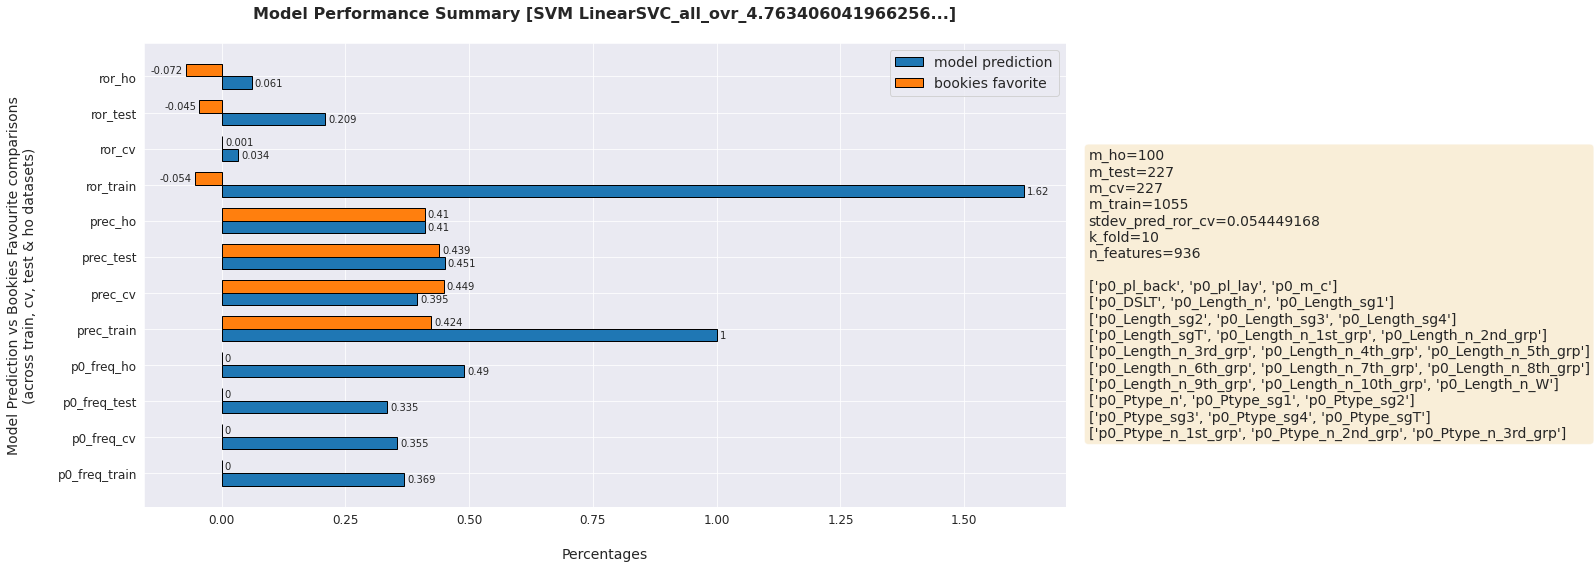

In [ ]:
df_bar = make_bars_all(best_mod_ror, df_results, k_fold)

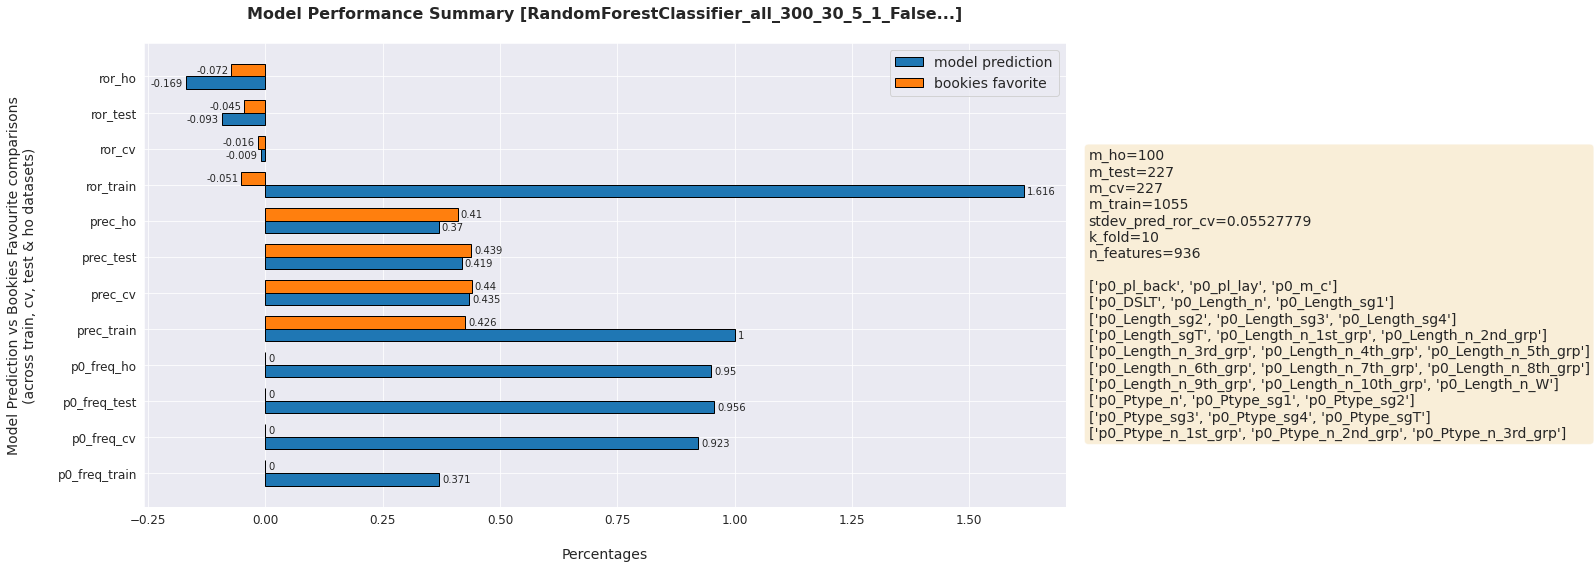

In [ ]:
df_bar = make_bars_all(best_mod_prec, df_results, k_fold)

In [ ]:
#Review ho results from model for all feature model
eval_ror_ho = calc_ror(Y_ho.astype('int'), pred_ho_ror, df_init_ho, p_res=1)
#eval_ror_ho = calc_ror(Y_ho.astype('int'), pred_ho_prec, df_init_ho, p_res=1)
print(f'\neval_ror_ho = {eval_ror_ho}')

L y_true=[0. 1. 0.], y_pred=[1. 0. 0.], prof=-1, odds=[2.36 2.66 4.2], ['jason kokrak', 'corey conners', 'cameron champ', '2021_6_17_v0_d2_grp34_PGA']
L y_true=[0. 1. 0.], y_pred=[0. 0. 1.], prof=-2, odds=[2.42 3.1 3.4], ['si woo kim', 'bernd wiesberger', 'kevin na', '2021_6_17_v0_d2_grp35_PGA']
L y_true=[1. 0. 0.], y_pred=[0. 0. 1.], prof=-3, odds=[2.72 2.92 3.15], ['dylan frittelli', 'martin laird', 'kyoung-hoon lee', '2021_6_17_v0_d2_grp37_PGA']
W y_true=[1. 0. 0.], y_pred=[1. 0. 0.], prof=-1.3599999999999999, odds=[2.64 2.7 3.5], ['ian poulter', 'ryan palmer', 'jimmy walker', '2021_6_17_v0_d2_grp38_PGA']
W y_true=[1. 0. 0.], y_pred=[1. 0. 0.], prof=0.1200000000000001, odds=[2.48 2.96 3.45], ['rafa cabrera bello', 'adrian meronk', 'sung kang', '2021_6_17_v0_d2_grp39_PGA']
W y_true=[1. 0. 0.], y_pred=[1. 0. 0.], prof=1.3000000000000003, odds=[2.18 2.4 5.7], ['adam hadwin', 'jt poston', 'joe long', '2021_6_17_v0_d2_grp40_PGA']
W y_true=[1. 0. 0.], y_pred=[1. 0. 0.], prof=2.30000000000

In [ ]:
#Review ho results from loaded model
from sklearn.svm import LinearSVC
import ast, pickle

#Load model and normalization parameters
loaded_model = pickle.load(open('ror_PGA_R2_3b_all_data.sav', 'rb'))  #ror_PGA_R1_3b_all_data.sav / prec_PGA_R1_3b_all_data.sav
mu = ast.literal_eval(list(df_results.loc[df_results['prod_mod']=='SVM LinearSVC_all_ovr_4.763406041966256', 'mu'])[0])
sigma = ast.literal_eval(list(df_results.loc[df_results['prod_mod']=='SVM LinearSVC_all_ovr_4.763406041966256', 'sigma'])[0])
X_ho, Y_ho, df_init_ho = X_ho_df.copy().values, Y_ho_df.copy().values, ho_data.copy()
#Normalize data
eval_norm = np.divide(np.subtract(X_ho, mu), sigma)
#Predict from loaded model & evaluate
eval_pred = loaded_model.predict(eval_norm)
eval_ror_loaded = calc_ror(Y_ho.astype('int'), eval_pred, df_init_ho, p_res=1)
try: print(f'\neval_ror_loaded = {eval_ror_loaded} ... eval_ror_ho = {eval_ror_ho}')
except NameError: print(f'\neval_ror_loaded = {eval_ror_loaded}')

L y_true=[0. 1. 0.], y_pred=[1. 0. 0.], prof=-1, odds=[2.36 2.66 4.2], ['jason kokrak', 'corey conners', 'cameron champ', '2021_6_17_v0_d2_grp34_PGA']
L y_true=[0. 1. 0.], y_pred=[0. 0. 1.], prof=-2, odds=[2.42 3.1 3.4], ['si woo kim', 'bernd wiesberger', 'kevin na', '2021_6_17_v0_d2_grp35_PGA']
L y_true=[1. 0. 0.], y_pred=[0. 0. 1.], prof=-3, odds=[2.72 2.92 3.15], ['dylan frittelli', 'martin laird', 'kyoung-hoon lee', '2021_6_17_v0_d2_grp37_PGA']
W y_true=[1. 0. 0.], y_pred=[1. 0. 0.], prof=-1.3599999999999999, odds=[2.64 2.7 3.5], ['ian poulter', 'ryan palmer', 'jimmy walker', '2021_6_17_v0_d2_grp38_PGA']
W y_true=[1. 0. 0.], y_pred=[1. 0. 0.], prof=0.1200000000000001, odds=[2.48 2.96 3.45], ['rafa cabrera bello', 'adrian meronk', 'sung kang', '2021_6_17_v0_d2_grp39_PGA']
W y_true=[1. 0. 0.], y_pred=[1. 0. 0.], prof=1.3000000000000003, odds=[2.18 2.4 5.7], ['adam hadwin', 'jt poston', 'joe long', '2021_6_17_v0_d2_grp40_PGA']
W y_true=[1. 0. 0.], y_pred=[1. 0. 0.], prof=2.30000000000